In [1]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

dados = pd.read_csv('/kaggle/input/rio-de-janeiro-airbnb-listings-2022/AirbnbRJRentals.csv')
dados.price

0        581
1        898
2        720
3        599
4        240
        ... 
28296    871
28297    194
28298    153
28299    457
28300    200
Name: price, Length: 28301, dtype: int64

In [2]:
dados_limpos = dados.dropna()
dados_limpos.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,1.978100e+04,1.978100e+04,19781.000000,19781.000000,19781.000000,19781.000000,19781.000000,19781.000000,19781.000000,19781.000000,19781.000000
mean,1.623352e+17,1.365249e+08,-22.968590,-43.244732,1208.160710,3.959001,25.040898,0.894192,8.602497,190.993529,8.808453
std,2.867422e+17,1.465510e+08,0.033421,0.095396,7355.949295,20.428644,43.059332,1.026601,24.374662,131.770325,11.802266
min,1.787800e+04,3.607000e+03,-23.072840,-43.689910,0.000000,1.000000,1.000000,0.010000,1.000000,0.000000,0.000000
25%,1.607912e+07,1.563791e+07,-22.984590,-43.289610,300.000000,2.000000,3.000000,0.190000,1.000000,65.000000,1.000000
50%,4.102455e+07,7.290590e+07,-22.973380,-43.194110,557.000000,2.000000,9.000000,0.540000,2.000000,176.000000,4.000000
75%,5.424722e+07,2.294729e+08,-22.960800,-43.185577,971.000000,3.000000,27.000000,1.240000,4.000000,329.000000,12.000000
max,7.900352e+17,4.918992e+08,-22.749690,-43.104400,500000.000000,999.000000,563.000000,18.170000,228.000000,365.000000,174.000000


In [3]:
dados_limpos = dados_limpos[dados_limpos.price < dados_limpos.price.std()]

# [0.0, 0.0, 1.0, 2.0, 3.0, 4.0, 6.0, 10.0, 15.0, 25.0, 174.0]
pd.DataFrame(dados_limpos['number_of_reviews_ltm'].quantile([0.1 * i for i in range(1, 10)]))


,number_of_reviews_ltm
0.1,0.0
0.2,1.0
0.3,2.0
0.4,3.0
0.5,4.0
0.6,6.0
0.7,10.0
0.8,15.0
0.9,25.0


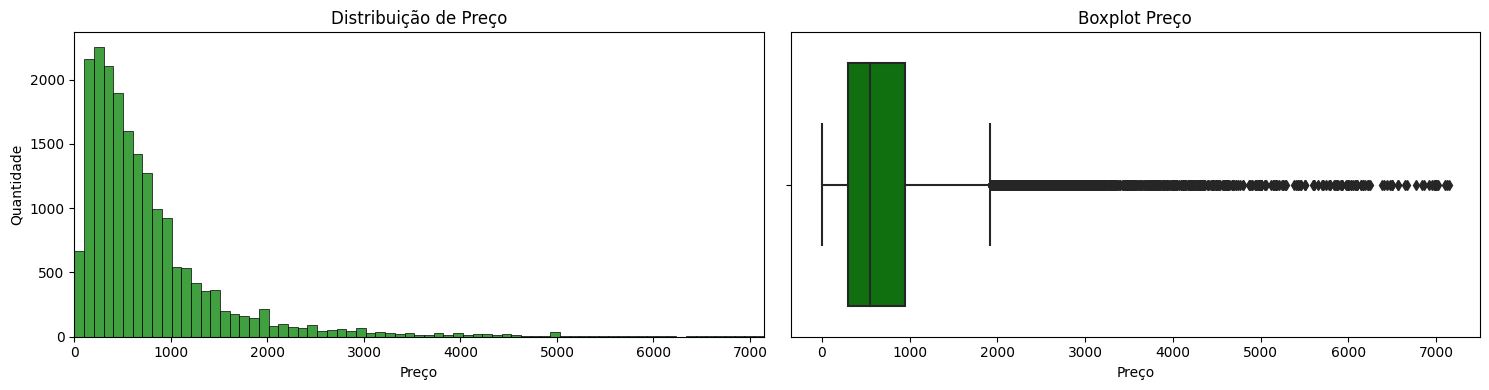

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(ncols = 2, sharey = False, figsize = (15, 4))

sns.histplot(dados_limpos['price'], kde = False, color='green', ax = ax1, bins= int(dados_limpos.price.max()/100)) # intervalos de tamanho 40
ax1.grid(False)
ax1.set_title('Distribuição de Preço')
ax1.set_ylabel('Quantidade')
ax1.set_xlabel('Preço')
ax1.set_xlim(0, dados_limpos.price.max())

sns.boxplot(x=dados_limpos['price'], ax = ax2, color='green')
ax2.grid(False)
ax2.set_xlabel('Preço')
ax2.set_title('Boxplot Preço')

plt.tight_layout()

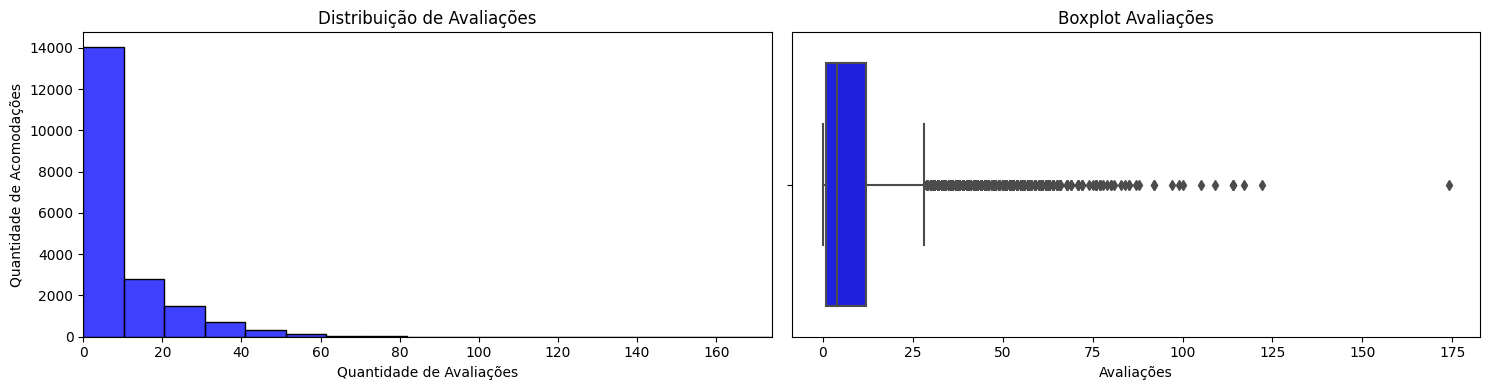

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, sharey = False, figsize = (15, 4))

sns.histplot(dados_limpos['number_of_reviews_ltm'], 
             kde = False, color='blue', ax = ax1, 
             bins= int(dados_limpos.number_of_reviews_ltm.max()/10)) # intervalos de tamanho 17
ax1.grid(False)
ax1.set_title('Distribuição de Avaliações')
ax1.set_ylabel('Quantidade de Acomodações')
ax1.set_xlabel('Quantidade de Avaliações')
ax1.set_xlim(0, dados_limpos.number_of_reviews_ltm.max())

sns.boxplot(x=dados_limpos['number_of_reviews_ltm'], ax = ax2, color='blue')
ax2.grid(False)
ax2.set_xlabel('Avaliações')
ax2.set_title('Boxplot Avaliações')

plt.tight_layout()

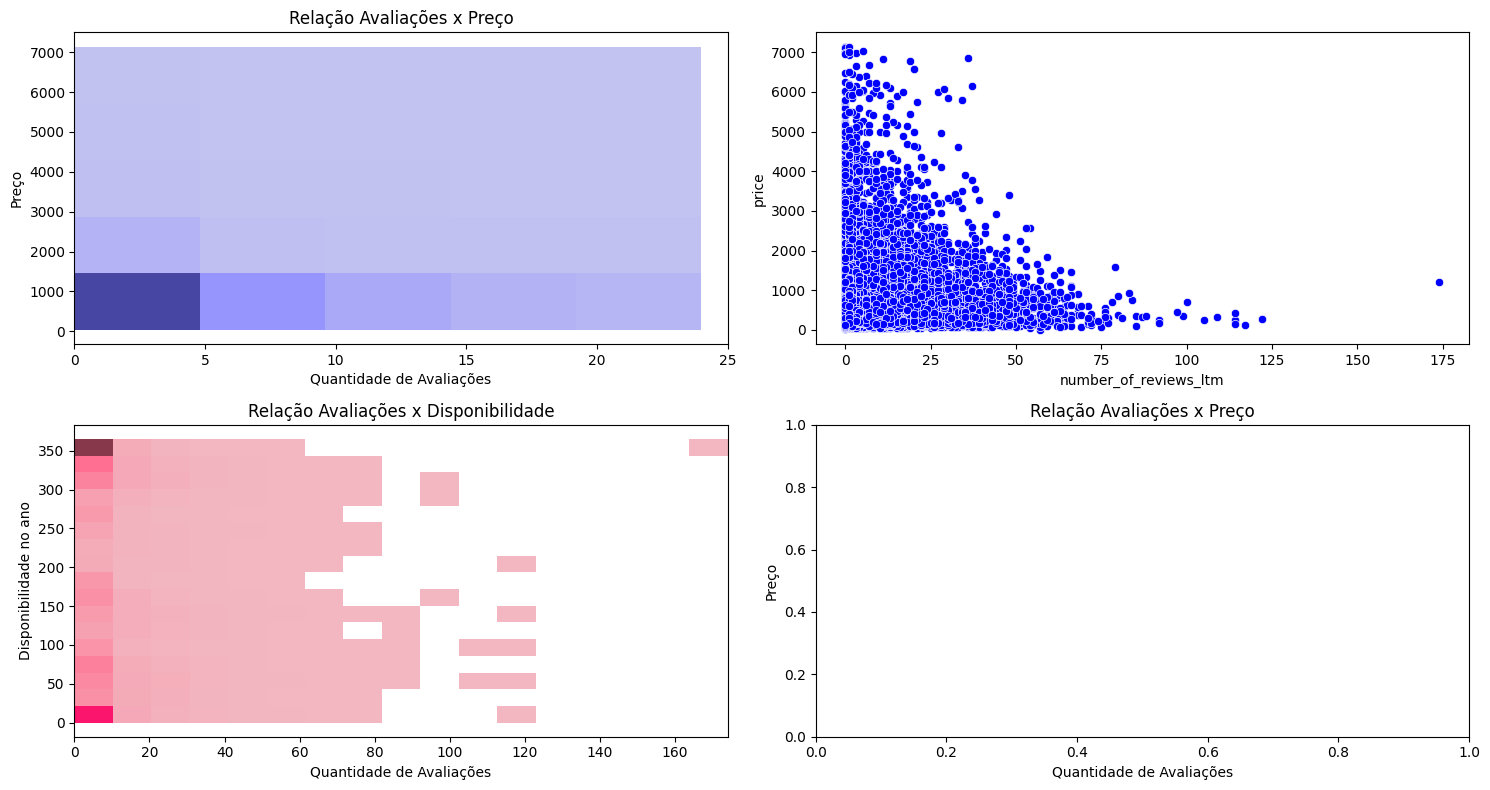

In [6]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols = 2, nrows=2, sharey = False, figsize = (15, 8))

hist = sns.histplot(x=dados_limpos[dados_limpos.number_of_reviews_ltm < 25]['number_of_reviews_ltm'], y=dados_limpos['price'], 
             kde = False, color='blue', ax = ax1, 
             bins= 5) # intervalos de tamanho 17
        
ax1.grid(False)
ax1.set_title('Relação Avaliações x Preço')
ax1.set_ylabel('Preço')
ax1.set_xlabel('Quantidade de Avaliações')
ax1.set_xlim(0, 25)

sns.scatterplot(x=dados_limpos['number_of_reviews_ltm'], y=dados_limpos['price'], color='blue', ax=ax2)
plt.title('Relação Avaliações x Preço',)
plt.xlabel('Quantidade de Avaliações')
plt.ylabel('Preço')

sns.histplot(x=dados_limpos['number_of_reviews_ltm'], y=dados_limpos['availability_365'], 
             kde = False, color='pink', ax = ax3, 
             bins= int(dados_limpos.number_of_reviews_ltm.max()/10)) # intervalos de tamanho 17
ax3.grid(False)
ax3.set_title('Relação Avaliações x Disponibilidade')
ax3.set_ylabel('Disponibilidade no ano')
ax3.set_xlabel('Quantidade de Avaliações')
ax3.set_xlim(0, dados_limpos.number_of_reviews_ltm.max())

# sns.boxplot(x=dados_limpos['number_of_reviews_ltm'], ax = ax4, color='blue')
# ax4.grid(False)
# ax4.set_xlabel('Avaliações')
# ax4.set_title('Boxplot Avaliações')

plt.tight_layout()